In [17]:
import gensim
import json
import glob

import sklearn.decomposition
import sklearn.manifold
import sklearn.preprocessing

from matplotlib import pyplot as plt

import music21

import numpy as np
import scipy as sp

In [2]:
%matplotlib inline
plt.style.use('ggplot')

In [3]:
paths_to_processed = glob.glob('data/json/*.json')

In [4]:
def load_corpus():
    corpus = []
    for fp in paths_to_processed:
        with open(fp, 'r') as f:
            obj = json.load(f)
        corpus.append(obj['rows'])
    return corpus

In [5]:
corpus = load_corpus()

In [6]:
len(corpus)

16983

In [7]:
def sentencify(corpus, stop='000000000000'):
    sentencified = []
    for document in corpus:
        stop_indices = [i for i, t in enumerate(document) if t == stop]
        splitted = [a.tolist() for a in np.split(document, stop_indices)]
        sentencified.extend(splitted)
    return sentencified

In [8]:
def transpose_to_all(c):
    out = []
    old = c
    for i in range(12):
        new = old.transpose(7)
        out.append(new)
        old = new
    return out

def transpose_to_some(c, degree):
    out = []
    out.append(c)
    old = c
    for i in range(degree):
        new = old.transpose(7)
        out.append(new)
        old = new
    return out
        
def c_to_strep(c):
    rep = ""
    for i in range(12):
        if i in c.pitchClasses:
            rep += "1"
        else:
            rep += "0"
    return rep

def strep_to_c(strep):
    pcs = []
    for i, v in enumerate(strep):
        if v == '1':
            pcs.append(i)
    return music21.chord.Chord(pcs)

def strep_to_symbol(strep):
    c = strep_to_c(strep)
    return music21.harmony.chordSymbolFigureFromChord(c)

In [9]:
def plot_relations(a, b,model=None,n_components=2,components=(0,1)):   
    words = list(model.vocab.keys())
    embeddings = np.array([model[w] for w in words])
    
    pca = sklearn.decomposition.PCA(n_components=n_components)
    
    proj = pca.fit_transform(embeddings)

    all_a = [c_to_strep(x) for x in transpose_to_all(a)]
    all_b = [c_to_strep(x) for x in transpose_to_all(b)]

    pairs = zip(all_a, all_b)
    focus = all_a + all_b
    
    q_words = [x for x in model.vocab.keys() if x in focus]
    
    q_indices = [words.index(x) for x in q_words]
    
    x=proj[q_indices,components[0]]
    y=proj[q_indices,components[1]]

    labels = [music21.harmony.chordSymbolFigureFromChord(strep_to_c(w)).split("/")[:1][0] for w in q_words]
    # labels = [chord2name[l] for l in labels]
    
    f, ax = plt.subplots()

    for lxy in zip(labels, x, y):
        ax.annotate(lxy[0], (lxy[1],lxy[2]), fontsize=12)
        
    def lookup_strep(strep):
        i = words.index(strep)
        return (proj[i, components[0]], proj[i, components[1]])
        
    arrows = [map(lookup_strep, pair) for pair in pairs]

    arrow_params = {'length_includes_head': True,
                    'head_starts_at_zero': True}
    
    for arrow in arrows:
        a = list(arrow)
        ax.arrow(a[0][0], a[0][1], a[1][0] - a[0][0], a[1][1] - a[0][1], alpha=1, 
             linewidth=1, head_width=.5, head_length=.5, ec='b', **arrow_params)
    
    ax.scatter(x, y, c='black')
        
    ax.set_title('PCA components {} vs. {}'.format(*components))

    ax.set_xlabel('PC{}'.format(components[0]))
    ax.set_ylabel('PC{}'.format(components[1]))
        
    plt.show()

In [11]:
model = gensim.models.Word2Vec(sentences=corpus[:15000])

KeyboardInterrupt: 

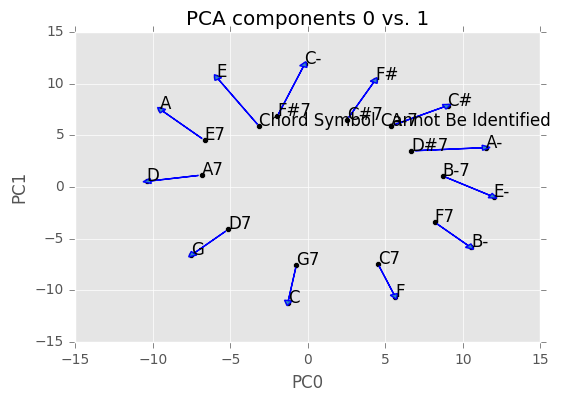

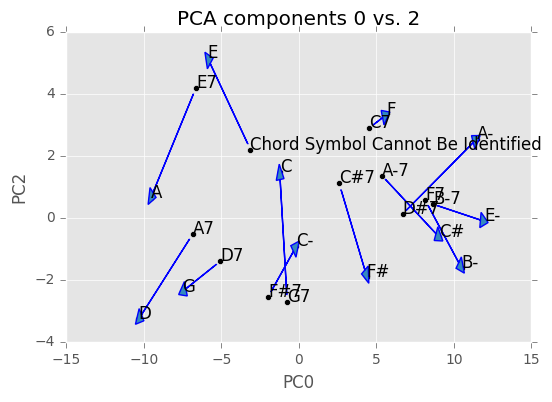

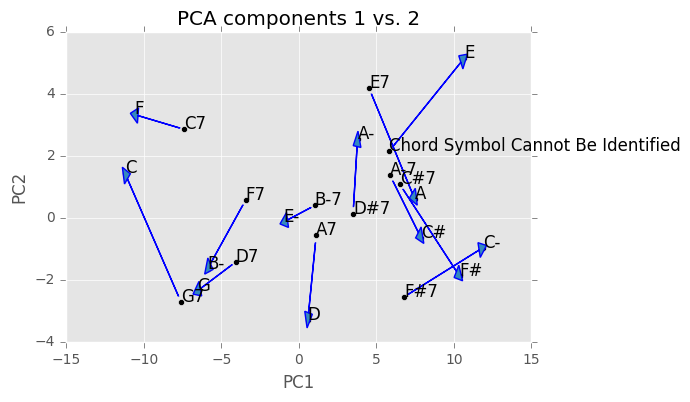

In [12]:
a = music21.chord.Chord(['D', 'F#', 'A', 'C'])
b = music21.chord.Chord(['G', 'B', 'D'])

plot_relations(a,b,model=model,n_components=3,components=(0,1))
plot_relations(a,b,model=model,n_components=3,components=(0,2))
plot_relations(a,b,model=model,n_components=3,components=(1,2))

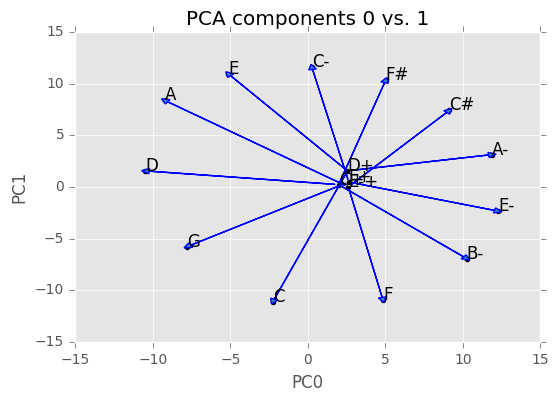

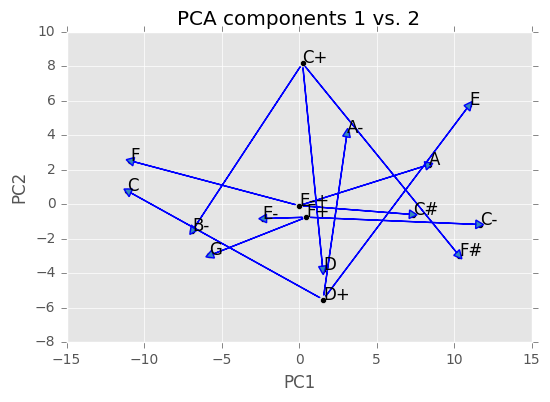

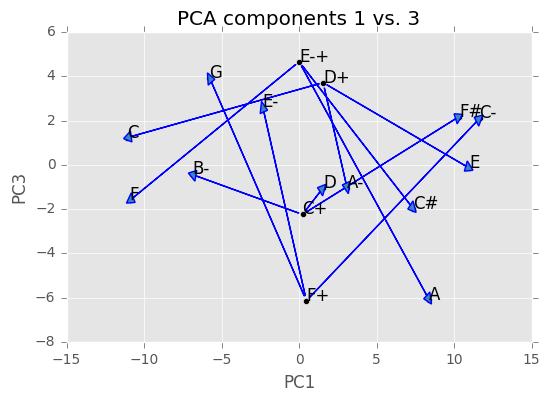

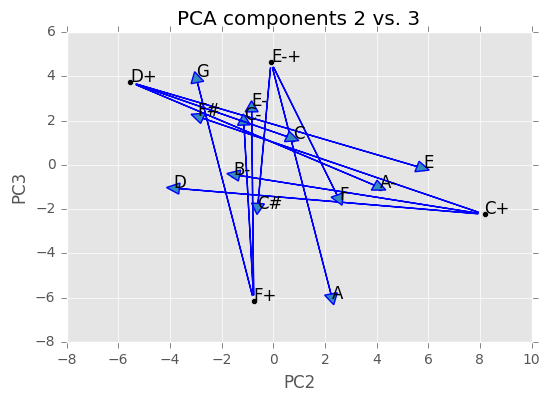

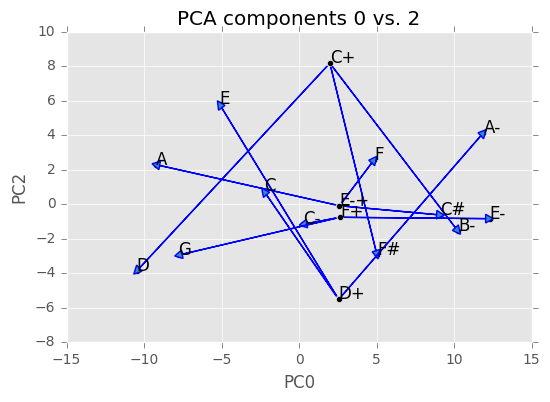

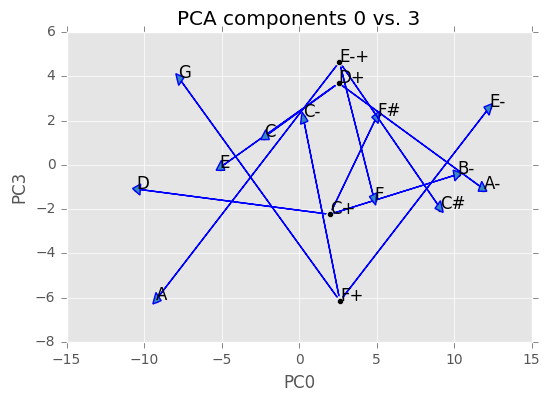

In [176]:
a = music21.chord.Chord(['A', 'C#', 'E#'])
b = music21.chord.Chord(['G', 'B', 'D'])
plot_relations(a,b,model=model,n_components=4,components=(0,1))
plot_relations(a,b,model=model,n_components=4,components=(1,2))
plot_relations(a,b,model=model,n_components=4,components=(1,3))

plot_relations(a,b,model=model,n_components=4,components=(2,3))
plot_relations(a,b,model=model,n_components=4,components=(0,2))
plot_relations(a,b,model=model,n_components=4,components=(0,3))




## tSNE

In [37]:
len(model.vocab)

4096

In [48]:
from collections import Counter

In [49]:
counts = Counter({k: v.count for k,v in model.vocab.items()})

In [81]:
counts['110010100011']

233

In [60]:
tsne = sklearn.manifold.t_sne.TSNE(n_components=2, random_state=0)
mfold = tsne.fit_transform(model.syn0)

In [106]:
pca = sklearn.decomposition.PCA(n_components=2)
red = pca.fit_transform(model.syn0)

In [107]:
red.shape

(4096, 2)

In [90]:
i2w = model.index2word

In [137]:
def color_finder(w, j, k, n):
    if w[j] == '1' and w[k] == '1' and counts[w] > n:
        return 'purple'
    elif w[j] == '1' and counts[w] > n:
        return 'r'
    elif w[k] == '1' and counts[w] > n:
        return 'b'
    else:
        return 'white'

In [165]:
colors = [color_finder(w,0,6,10000) for w in i2w]

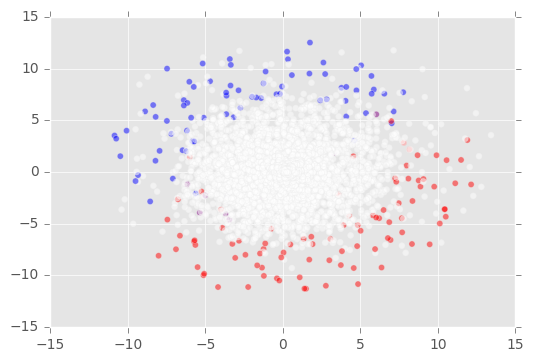

In [166]:
plt.scatter(red[:,0], red[:,1], c=colors,alpha=0.5)

## Multiple regression test

In [14]:
words = list(model.vocab.keys())
embeddings = np.array([model[w] for w in words])
    
pca = sklearn.decomposition.PCA(n_components=2)
    
proj = pca.fit_transform(embeddings)

In [55]:
def word_to_binvec(w):
    return np.array([int(i) for i in w])

def cart2pol(x, y):
    theta = np.arctan2(y, x)
    rho = np.hypot(x, y)
    return theta, rho

In [59]:
projpol = np.array([cart2pol(*a) for a in proj])

In [63]:
projpol[:,0]

array([ 2.44738108, -2.82202743, -0.91281253, ...,  1.09122872,
        0.73969041, -0.97748222])

In [31]:
four_mag = np.array([np.absolute(np.fft.rfft(word_to_binvec(w))) for w in words])

In [64]:
X = four_mag
y = projpol[:,0]

In [65]:
X.shape, y.shape

((4096, 7), (4096,))

In [66]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.5, train_size=0.5)

In [71]:
lm = sklearn.linear_model.LinearRegression()

In [72]:
lm.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [73]:
lm.score(X, y)

0.023112460615583919

## Pieces as paths thru embedding space

In [76]:
words = list(model.vocab.keys())
embeddings = np.array([model[w] for w in words])
    
pca = sklearn.decomposition.PCA(n_components=2)
    
proj = pca.fit_transform(embeddings)

In [79]:
def piece_to_path(piece):
    return np.array([proj[words.index(w)] for w in piece])
    

In [99]:
from collections import Counter

In [116]:
def plot_piece(piece, color,simplification):
    piece_counter = Counter(piece)
    most_common = list(dict(piece_counter.most_common(simplification)).keys())
    simpler_piece = [t for t in piece if t in most_common]
    path = piece_to_path(simpler_piece)
    plt.plot(path[:,0], path[:,1],color,alpha=.4)

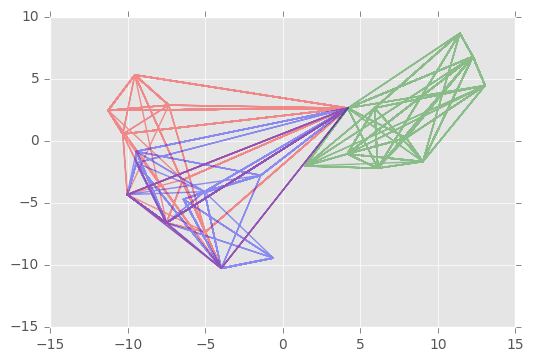

In [127]:
plot_piece(corpus[65], 'r', simplification=10)
plot_piece(corpus[25], 'g', simplification=10)
plot_piece(corpus[105], 'b', simplification=10)